In [1]:
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

2024-07-04 08:51:41.500456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 08:51:41.500605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 08:51:41.635039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## These are 28 × 28 grayscale images (pixel values between 0 and 255) out of the box, which we need to preprocess to ensure that the pixel values are scaled between 0 and 1. We will also pad each image to 32 × 32 for easier manipulation.

In [2]:
import numpy as np

def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# now check the new tensors shape
x_train.shape, x_test.shape

((60000, 32, 32, 1), (10000, 32, 32, 1))

# The Autoencoder Architecture
An autoencoder is a neural network made up of two parts:
* An encoder network that compresses high-dimensional input data such as an image into a lower-dimensional embedding vector
* A decoder network that decompresses a given embedding vector back to the original domain (e.g., back to an image)
A diagram of the network architecture is shown in Figure 3-4. An input image is encoded to a latent embedding vector z, which is then decoded back to the original pixel space.

<img src="https://raw.githubusercontent.com/cyb0rg14/generative-deep-learning/master/images/autoencoder.png" alt="Autoencoder architecture diagram" width="1000" height="600">

The autoencoder is trained to reconstruct an image, after it has passed through the encoder and back out through the decoder. This may seem strange at first—why would you want to reconstruct a set of images that you already have available to you? However, as we shall see, it is the embedding space (also called the latent space) that is the interesting part of the autoencoder, as sampling from this space will allow us to generate new images.

Let’s first define what we mean by an embedding. The embedding (z) is a compression of the original image into a lower-dimensional latent space. The idea is that by choosing any point in the latent space, we can generate novel images by passing this point through the decoder, since the decoder has learned how to convert points in the latent space into viable images.

In our example, we will embed images into a two-dimensional latent space. This will help us to visualize the latent space, since we can easily plot points in 2D. In practice, the latent space of an autoencoder will usually have more than two dimensions in order to have more freedom to capture greater nuance in the images.

In [3]:
# let's code encoder

from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary() # check the model definition

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# let's code the decoder

decoder_input = layers.Input(shape=(2, ), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary() # check decoder model definition

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# joining the encoder and decoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))

# Choosing the Loss Function
Optimizing for RMSE means that your generated output will be symmetrically distributed around the average pixel values (because an overestimation is penalized equivalently to an underestimation). On the other hand, binary cross-entropy loss is asymmetrical—it penalizes errors toward the extremes more heavily than errors toward the center. For example, if the
true pixel value is high (say 0.7), then generating a pixel with value 0.8 is penalized more heavily than generating a pixel with value 0.6. If the true pixel value is low (say 0.3), then generating a pixel with value 0.2 is penalized more heavily than generating a pixel with value 0.4.

This has the effect of binary cross-entropy loss producing slightly blurrier images than RMSE loss (as it tends to push predictions toward 0.5), but sometimes this is desirable as RMSE can lead to obviously pixelized edges. There is no right or wrong choice—you should choose whichever works best for your use case after experimentation.

In [6]:
# compiling autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [7]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
 25/600 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6659

I0000 00:00:1720083122.824626      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720083122.848759      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3619

W0000 00:00:1720083127.754825      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.3618 - val_loss: 0.2618
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2577 - val_loss: 0.2552
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2530 - val_loss: 0.2533
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2513 - val_loss: 0.2518
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2500 - val_loss: 0.2509


# Reconstructing Images
We can test the ability to reconstruct images by passing images from the test set through the autoencoder and comparing the output to the original images.

In [8]:
example_images = x_test[:5000]
predictions = autoencoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


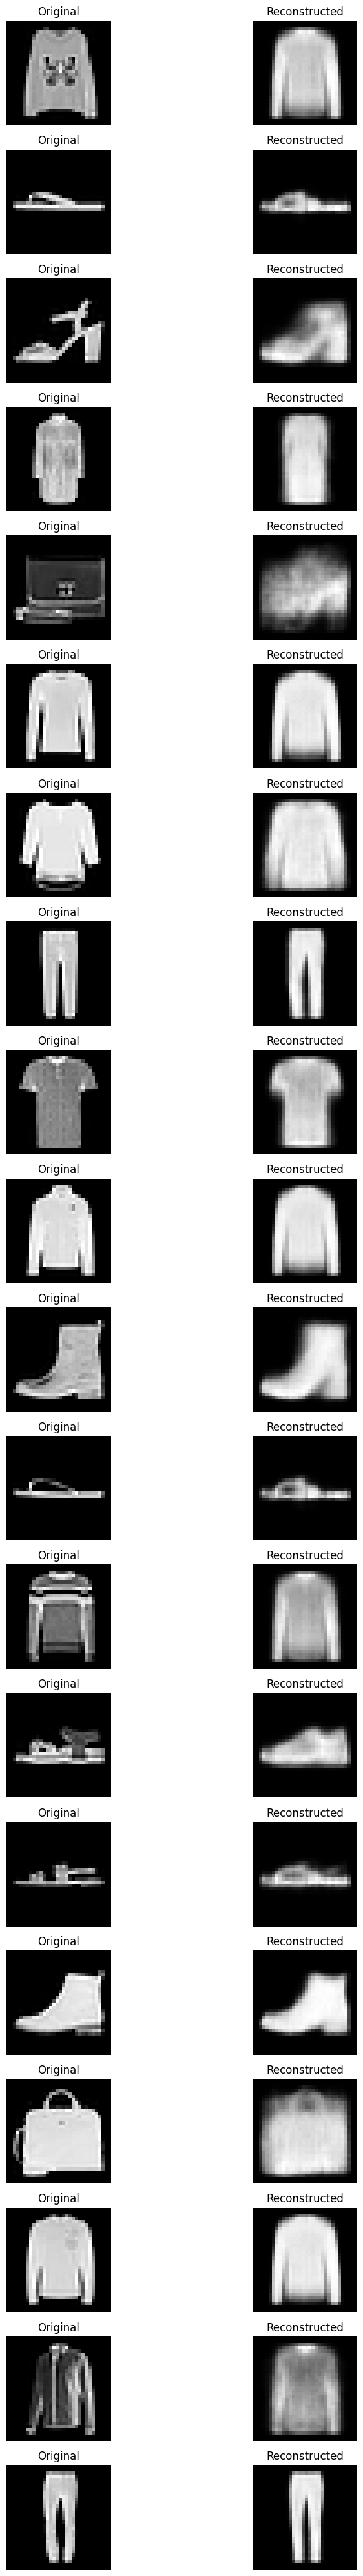

In [9]:
import matplotlib.pyplot as plt

num_images = 20
random_indices = np.random.choice(len(example_images), num_images, replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

# Plot images
for i, idx in enumerate(random_indices):
    # Plot original image
    axes[i, 0].imshow(example_images[idx].reshape(32, 32), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # Plot reconstructed image
    axes[i, 1].imshow(predictions[idx].reshape(32, 32), cmap='gray')
    axes[i, 1].set_title('Reconstructed')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

Notice how the reconstruction isn’t perfect—there are still some details of the original images that aren’t captured by the decoding process, such as logos. This is because by reducing each image to just two numbers, we naturally lose some information.

Let’s now investigate how the encoder is representing images in the latent space.

# Visualizing the Latent Space
We can visualize how images are embedded into the latent space by passing the test set through the encoder and plotting the resulting embeddings.

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


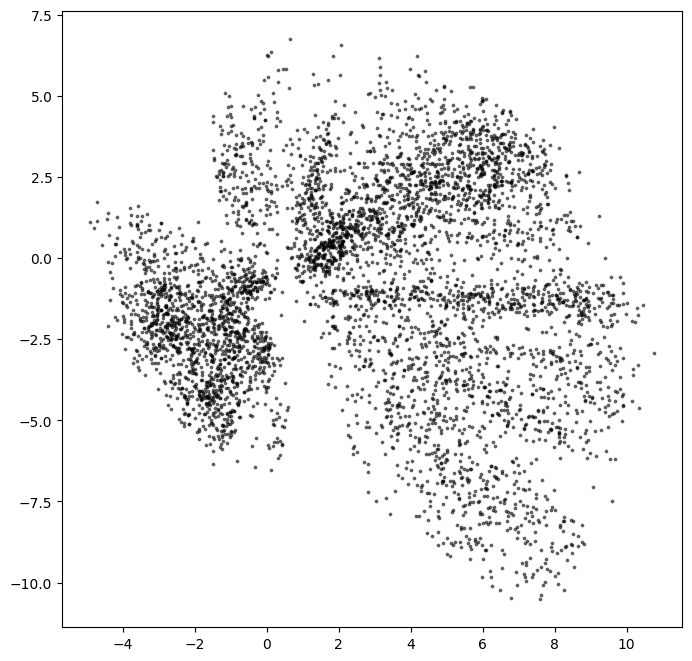

In [10]:
embeddings = encoder.predict(example_images)
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In order to better understand how this latent space is structured, we can make use of the labels that come with the Fashion-MNIST dataset, describing the type of item in each image.

{
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

We can color each point based on the label of the corresponding image to produce the plot in figure represented below. Now the structure becomes very clear! Even though the clothing labels were never shown to the model during training, the autoencoder has naturally grouped items that look alike into the same parts of the latent space. For example, the dark blue cloud of points in the bottom-right corner of the latent space are all different images of trousers and the red cloud of points toward the center are all ankle boots.

<img src="https://raw.githubusercontent.com/cyb0rg14/generative-deep-learning/master/images/colored_latent_space_autoencoder.png" alt="Plot of the latent space, colored by clothing label" width="700" height="400">

In [11]:
# generating new images
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxs, size=(18, 2))
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


<img src="https://raw.githubusercontent.com/cyb0rg14/generative-deep-learning/master/images/autoencoder_generation_clothing.png" alt="Generated items of clothing" width="1000" height="800">

Each blue dot maps to one of the images shown on the right of the diagram, with the embedding vector shown underneath. Notice how some of the generated items are more realistic than others. Why is this?

To answer this, let’s first make a few observations about the overall distribution of points in the latent space, referring back to above figure:
* Some clothing items are represented over a very small area and others over a much larger area.
* The distribution is not symmetrical about the point (0, 0), or bounded. For example, there are far more points with positive y-axis values than negative, and some points even extend to a y-axis value > 8.
* There are large gaps between colors containing few points.

In two dimensions this issue is subtle; the autoencoder only has a small number of dimensions to work with, so naturally it has to squash clothing groups together, resulting in the space between clothing groups being relatively small. However, as we start to use more dimensions in the latent space to generate more complex images such as faces, this problem becomes even more apparent. If we give the autoencoder free rein over how it uses the latent space to encode images, there will be huge gaps between groups of similar points with no incentive for the spaces in between to generate well-formed images.

In order to solve these three problems, we need to convert our autoencoder into a variational autoencoder. Tomorrow I will be implementing Variational Autoencoder from scratch using Keras. 

## *And yeah if you don't know, I've been running this new* **Generative Deep Learning** *series. Where I am learning and explaining the concepts of the future. If you want to follow along, you could check out my* **[github repo](https://github.com/cyb0rg14/generative-deep-learning)**